# Partly independent MLP model with uncertainty estimation (version without normalisation)

-- Network outputs two values in the final layer, corresponding to the predicted **mean** and **variance** by treating the observed value as a sample from a Gaussian distribution (one shared MLP and 22 independent models)

In [1]:
import sys, os, glob
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from astropy.io import fits
import numpy.ma as ma
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.models_mlp import MlpPartlyIndepNet
from inverse_problem.nn_inversion.transforms import normalize_output, mlp_transform_unnorm
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer
from inverse_problem.nn_inversion.transforms import inverse_transformation
from inverse_problem.nn_inversion.posthoc import plot_hist_params_comparison
from inverse_problem.nn_inversion.posthoc import plot_analysis_hist2d_unc
from inverse_problem.nn_inversion.posthoc import plot_spectrum, plot_model_spectrum, read_spectrum_for_refer
from inverse_problem.nn_inversion import mlp_transform_rescale, normalize_spectrum

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

### Load data

In [3]:
filename = '../data/parameters_base_new.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

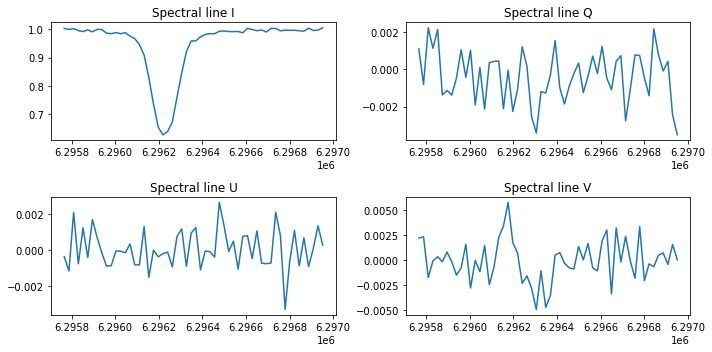

In [4]:
line_type = ['I','Q','U','V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2,2, figsize = (10,5))
for i in range(4):
    ax[i//2][i%2].plot(line_arg, sample['X'][0][:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight = True)

### Prepare data for training

Options:
-- angle transformation
-- log transformation

In [5]:
names = ['Field_Strength',
 'Field_Inclination',
 'Field_Azimuth',
 'Doppler_Width',
 'Damping',
 'Line_Strength',
 'Source_Function',
 'Source_Function_Gradient',
 'Doppler_Shift2',
 'Stray_Light_Fill_Factor',
 'Stray_Light_Shift']

In [6]:
params = fits.open(filename)[0].data
def params_masked_rows(pars_arr):
    max_par_values = np.array([par_arr.max() for par_arr in pars_arr.T])
    min_par_values = np.array([par_arr.min() for par_arr in pars_arr.T])
    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return np.all(bool_arr, axis=1)

def create_masked_array(pars_arr):
    rows_mask = params_masked_rows(pars_arr)
    array_mask = rows_mask[:, np.newaxis] | np.zeros_like(pars_arr, dtype=bool)
    return ma.masked_array(pars_arr, mask=~array_mask)
rows_mask_params = params_masked_rows(params)
filtered_params = params[rows_mask_params, :]

In [7]:
factors = [1,1000,1000,1000]
cont_scale= 40000
angle_transformation = False
logB = False

train_loader, val_loader = make_loader(data_arr=filtered_params, transform_name='mlp_transform_unnorm',
                                       factors = factors, cont_scale= cont_scale,
                                       angle_transformation = angle_transformation, logB = logB,
                                       batch_size=128)

sample_batch = next(iter(train_loader))
print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
print(f"Number of batches for train: {len(train_loader)}, for validation: {len(val_loader)}")

torch.Size([128, 224]) torch.Size([128, 1]) torch.Size([128, 11])
Number of batches for train: 31243, for validation: 3472


### Create path for saving

In [35]:
model_name = 'unc_pred_unnorm'
current_time = str(datetime.now().strftime('%m-%d_%H-%M'))
save_path = '../' + model_name + '_' + current_time + '/'
Path(save_path).mkdir(parents=True, exist_ok=True)
save_path

'../unc_pred_unnorm_02-10_08-55/'

### Define model

output_dim=22 for uncertainty estimation

In [8]:
model = MlpPartlyIndepNet(input_dim=224, output_dim=22, hidden_dims=[200, 200, 200],
                           activation='elu', batch_norm=True, dropout=0.05, number_readout_layers=2);

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
model.to(device);

In [109]:
def mdn_cost(mu, sigma, y):
    if np.max(sigma.detach().cpu().numpy()) > 1:
        raise AssertionError('not a valid value for the sigma')
    dist = torch.distributions.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))

def fit_step(dataloader, max_steps=None):
    train_loss = 0.0
    train_it = 0
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break
            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)
            outputs = model(x)
            outputs_mean = outputs[:, :11]
            outputs_sigma = torch.sigmoid(outputs[:, 11:])
            optimizer.zero_grad()
            losses = [mdn_cost(outputs_mean[:, ind], outputs_sigma[:, ind], y[:, ind])
                      for ind in range(11)]
            loss = torch.stack(losses).mean()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_it += 1

            if train_it % 10 == 0:
                pbar_outer.update(10)

        return train_loss / train_it


def eval_step(dataloader, max_steps = None):
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps,len(dataloader))
    model.eval()
    val_loss = 0.0
    val_it = 0
    for i, inputs in enumerate(dataloader):
        if i==total:
            break
        x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
        y = inputs['Y'].to(device)

        with torch.no_grad():
            outputs = model(x)
            outputs_mean = outputs[:, :11]
            outputs_sigma = torch.sigmoid(outputs[:, 11:])
            losses = [mdn_cost(outputs_mean[:, ind], outputs_sigma[:, ind], y[:, ind])
                      for ind in range(11)]
            loss = torch.stack(losses).mean()
            val_loss += loss.item()
            val_it += 1
    return val_loss / val_it


def save_model(epoch, loss, path='../'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss},
        path + f'ep{epoch}.pt')

### Train model

In [116]:
# %%time
# max_train_steps, max_val_steps = None, None
# best_valid_loss = float('inf')
# history, loss_history = [], []
# log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
# n_epochs = 3
# log_dir=save_path
# with tqdm(desc="epoch", total = n_epochs, position=0, leave=True) as pbar_outer:
#     for epoch in range(n_epochs):
#         train_loss = fit_step(train_loader, max_train_steps)
#         val_loss = eval_step(val_loader, max_val_steps)
#         history.append((train_loss, val_loss))
#         if val_loss < best_valid_loss:
#             best_valid_loss = val_loss
#             save_model(epoch, val_loss, save_path)
#         pbar_outer.update(1)
#         tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss,
#                                                v_loss=val_loss))

batch:   0%|          | 0/10000 [00:00<?, ?it/s]1s/it]


Epoch 001 train_loss: 158360.6617 val_loss 139152.8047


batch:   0%|          | 0/10000 [00:00<?, ?it/s]7s/it]


Epoch 002 train_loss: 126749.5108 val_loss 138333.3377


epoch: 100%|██████████| 3/3 [1:05:18<00:00, 1306.26s/it]


Epoch 003 train_loss: 114062.4324 val_loss 117149.2648
CPU times: user 1h 12min 16s, sys: 1min 9s, total: 1h 13min 25s
Wall time: 1h 5min 18s


### Load the model weights

In [10]:
model = MlpPartlyIndepNet(input_dim=224, output_dim=22, hidden_dims=[200, 200, 200],
                          activation='elu', batch_norm=True, dropout=0.05, number_readout_layers=2);

save_path = '../unc_pred_unnorm_02-14_00-06/'
n_epochs = 6

checkpoint_path = save_path + 'ep' + str(n_epochs - 1) + '.pt'
model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])

<All keys matched successfully>

## Results analysis
### Simulation based on the refer file

Data source: https://drive.google.com/drive/folders/1bv-KLMI67kiGNxlOjkJha2UmVggjV-sa?usp=sharing

In [11]:
path_to_refer = '../data/sp_20140926_170005/20140926_170005.fits'
data, names = open_param_file(path_to_refer, normalize=False, angle_transformation = angle_transformation, logB = logB)
print(data.shape)

Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift
(512, 873, 11)


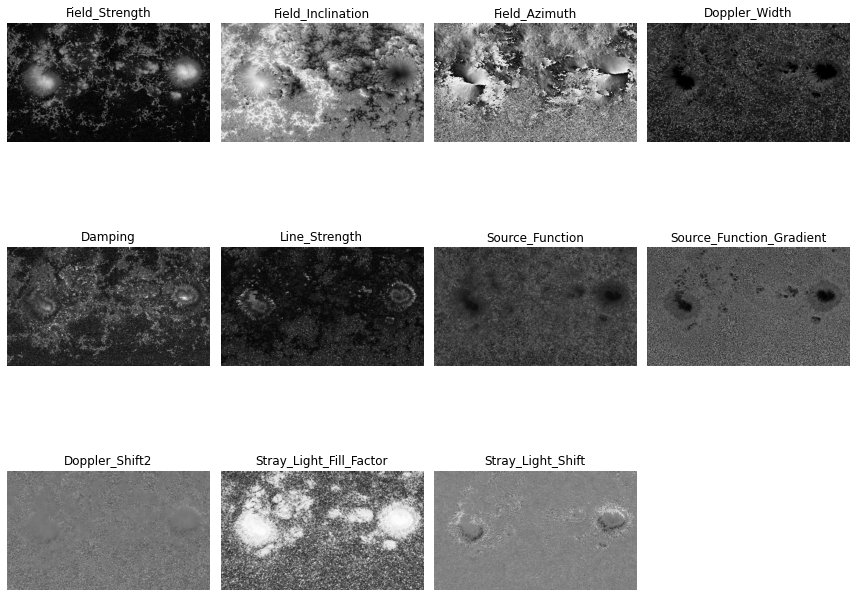

In [12]:
plot_params(data, names=names)

In [13]:
%%time


factors = [1,1000,1000,1000]
cont_scale= 40000

transform = mlp_transform_unnorm(factors = factors, angle_transformation=angle_transformation,
                                  cont_scale=cont_scale, logB = logB)
test_dataset = PregenSpectrumDataset(param_path=path_to_refer, source='refer', transform=transform)


CPU times: user 38.7 s, sys: 24.9 s, total: 1min 3s
Wall time: 1min 16s


In [14]:
inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
y = inputs['Y'].to(device)

In [15]:
%%time

model.eval()
with torch.no_grad():
    predicted = model(sim_x)

CPU times: user 28.7 s, sys: 4.5 s, total: 33.2 s
Wall time: 22.4 s


In [16]:
predicted_mean = predicted[:, :11].detach().cpu().numpy()
predicted_sigma = torch.exp(predicted[:, 11:]).detach().cpu().numpy()

In [17]:
data_2d = data.reshape(-1, 11)
refer_shape = data.shape
print('\n', refer_shape, data_2d.shape, y.shape, predicted_mean.shape)


 (512, 873, 11) (446976, 11) torch.Size([446976, 11]) (446976, 11)


In [30]:
ref_2d = data_2d.copy()
refer = ref_2d.reshape(refer_shape).copy()

In [31]:
masked_ref_2d = create_masked_array(ref_2d)
masked_ref = masked_ref_2d.reshape(refer.shape)

In [41]:
compute_metrics(normalize_output(data_2d.copy(),logB=logB,angle_transformation=angle_transformation),
                normalize_output(predicted_mean.copy(),logB=logB, angle_transformation=angle_transformation),
                save_path=save_path + 'metrics.csv',
                mask=None)

,r2,mse,mae
Field Strength,0.9827,0.0002,0.0088
Field Inclination,0.9361,0.0027,0.0222
Field Azimuth,0.6666,0.0261,0.0847
Doppler Width,0.9545,0.0009,0.0194
Damping,0.9282,0.0016,0.0226
Line Strength,0.7628,0.0033,0.0217
S_0,0.8647,0.0007,0.0163
S_1,0.9706,0.0003,0.0108
Doppler Shift,0.9222,0.0001,0.0058
Filling Factor,0.8438,0.0105,0.0671


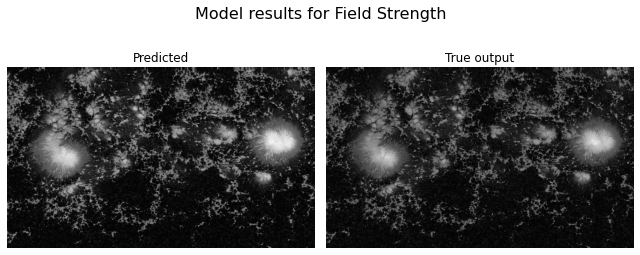

In [28]:
plot_pred_vs_refer(predicted_mean, masked_ref.data, output_index=0, save_path=save_path, title='refer')

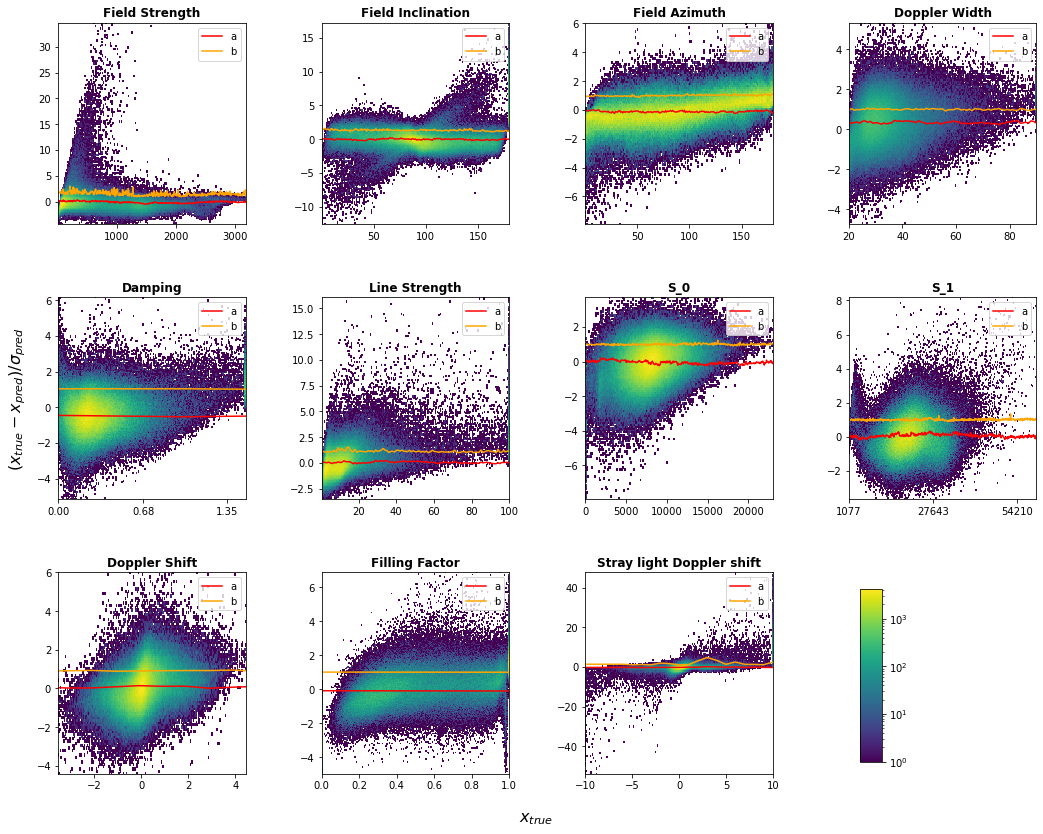

In [27]:
plot_analysis_hist2d_unc(data_2d, predicted_mean, predicted_sigma, index=0, bins=300, save_path=save_path, title='refer', plot_stats=True);

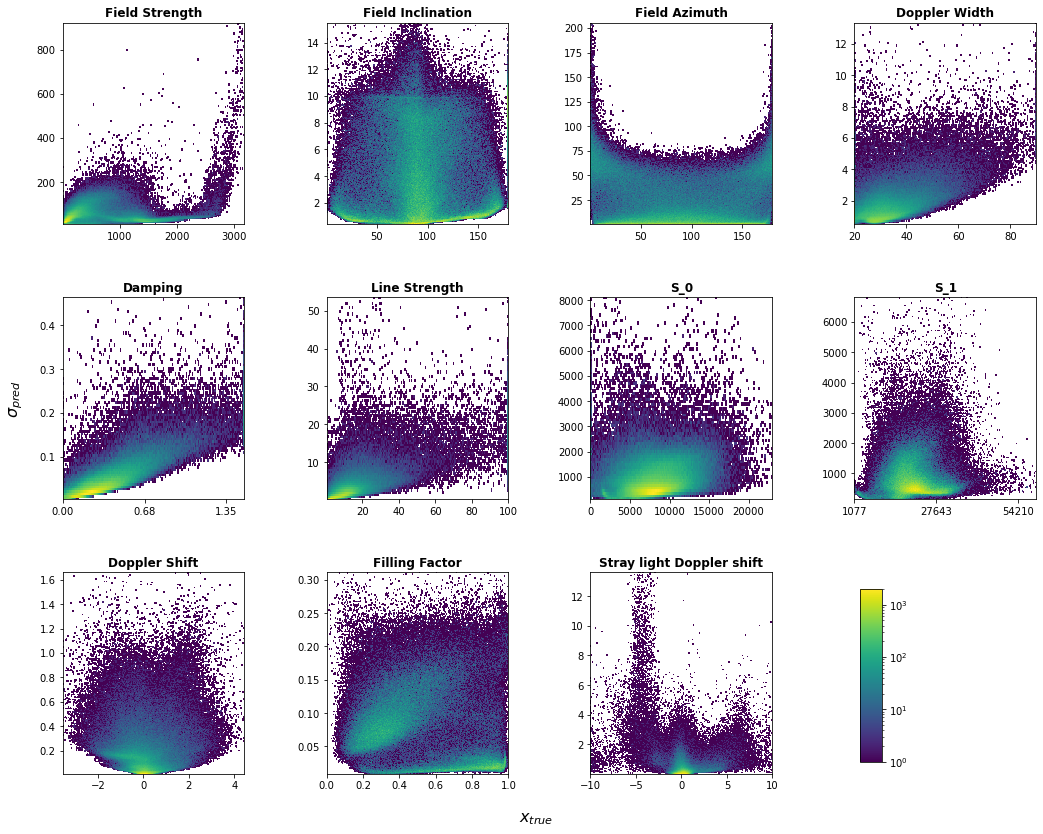

In [28]:
plot_analysis_hist2d_unc(data_2d, predicted_mean, predicted_sigma, index=2, bins=300, save_path=save_path, title='refer', plot_stats=False);

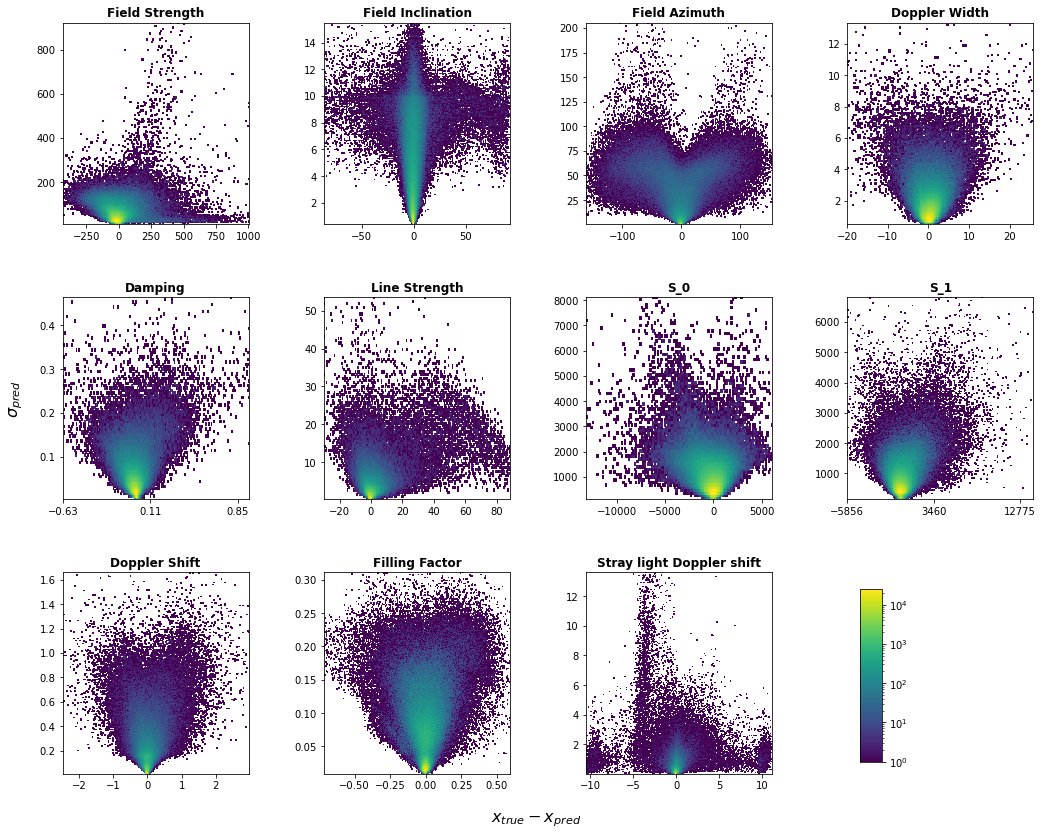

In [29]:
plot_analysis_hist2d_unc(data_2d, predicted_mean, predicted_sigma, index=1, bins=300, save_path=save_path, title='refer', plot_stats=False);

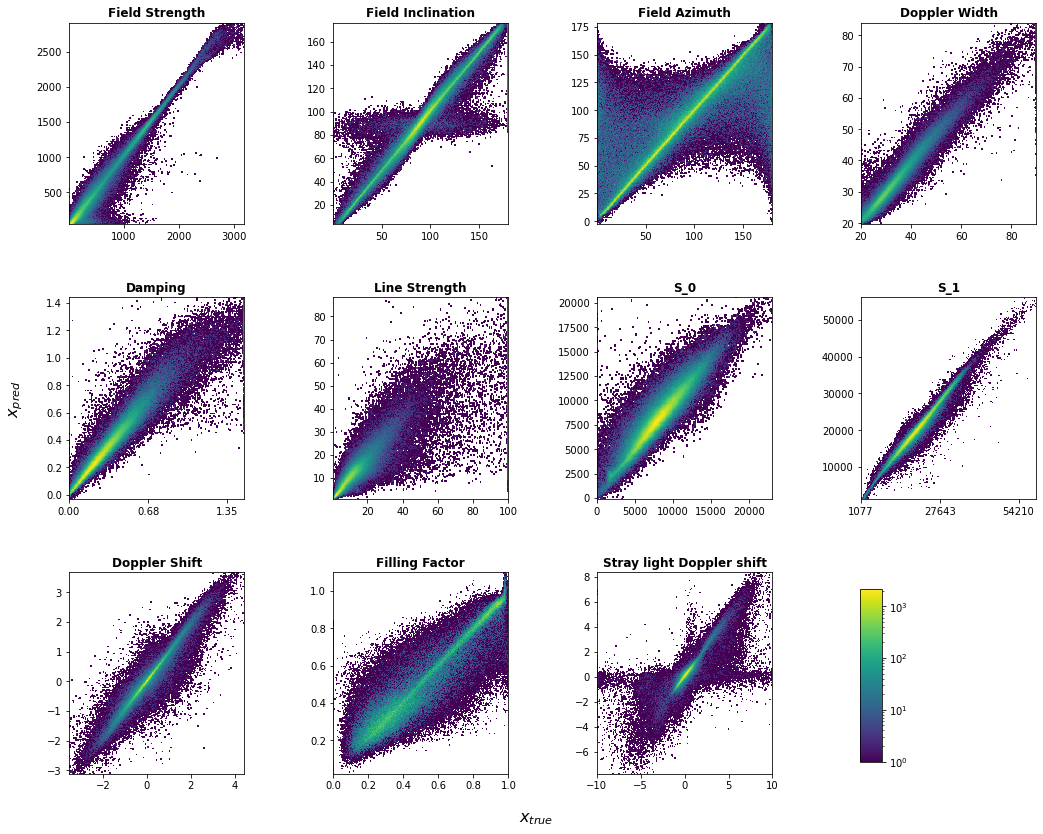

In [25]:
from inverse_problem.nn_inversion.posthoc import plot_analysis_hist2d_unc
plot_analysis_hist2d_unc(data_2d, predicted_mean, predicted_sigma, index=3, bins=300, save_path=save_path, title='refer', plot_stats=False);

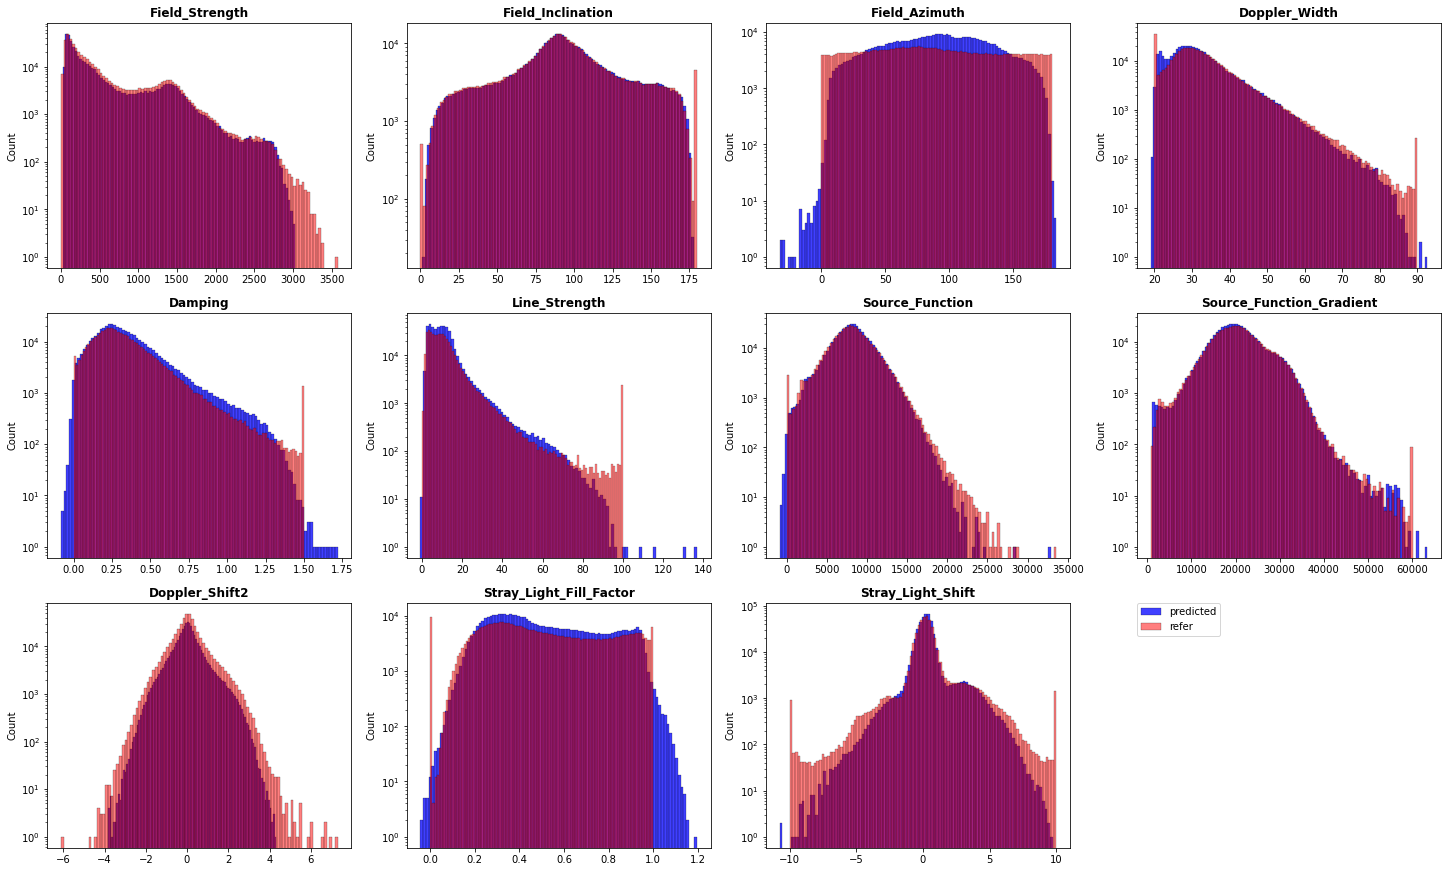

In [37]:
from inverse_problem.nn_inversion.posthoc import plot_hist_params_comparison
plot_hist_params_comparison(predicted_mean, data_2d, names, plot_name='refer', save_path=save_path)

### Real spectra
Data source: https://csac.hao.ucar.edu/fg_download.php

In [29]:
path_to_folder = '../data/'
#date as a list with year, month,day, hour
date = ['2014','09','26','17']
sp_folder = os.path.join(path_to_folder, 'sp_20140926_170005')
sp_path = os.path.join(sp_folder,date[0],date[1],date[2],'SP3D')
sp_path = glob.glob(f'{sp_path}/*/')[0]
sp_lines =  sorted(glob.glob(sp_path+'*.fits'))
print(f'Number of files: {len(sp_lines)}')

Number of files: 873


In [30]:
def open_spectrum_data(sp_folder, date, idx):
    """
    path should start from the folder included in level1 folder, with data year
    only for this path_to_folder like this sp_20140926_170005
    """
    sp_path = os.path.join(sp_folder,date[0],date[1],date[2],'SP3D')
    sp_path = glob.glob(f'{sp_path}/*/')[0]
    sp_lines =  sorted(glob.glob(sp_path+'*.fits'))
    #print(f'Number of files: {len(sp_lines)}')
    return fits.open(sp_lines[idx])
def real_spectra(spectra_file):
    """
    Extracting and plotting spectral lines from fits
    Why multiply to numbers?
    """
    real_I = spectra_file[0].data[0][:,56:].astype('float64')*2
    real_Q = spectra_file[0].data[1][:,56:].astype('float64')
    real_U = spectra_file[0].data[2][:,56:].astype('float64')
    real_V = spectra_file[0].data[3][:,56:].astype('float64')
    return np.concatenate((real_I, real_Q, real_U, real_V), axis = 1)

Real spectrum for parameters
Model spectrum for parameters
Field_Strength: 483.10, Field_Inclination: 127.89, Field_Azimuth: 67.10, Doppler_Width: 25.90, Damping: 0.33, Line_Strength: 10.72, Source_Function: 8626.69, Source_Function_Gradient: 21277.41, Doppler_Shift2: -0.11, Stray_Light_Fill_Factor: 0.46, Stray_Light_Shift: -0.13


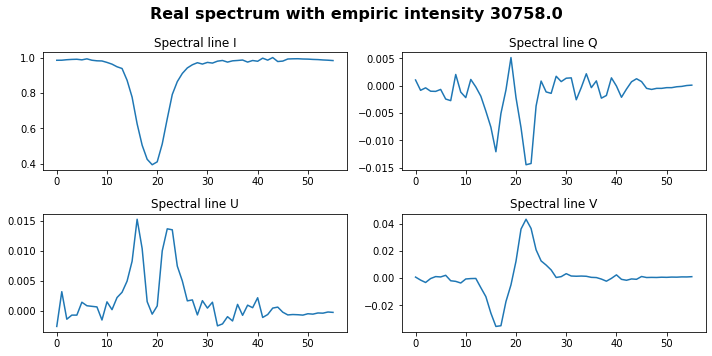

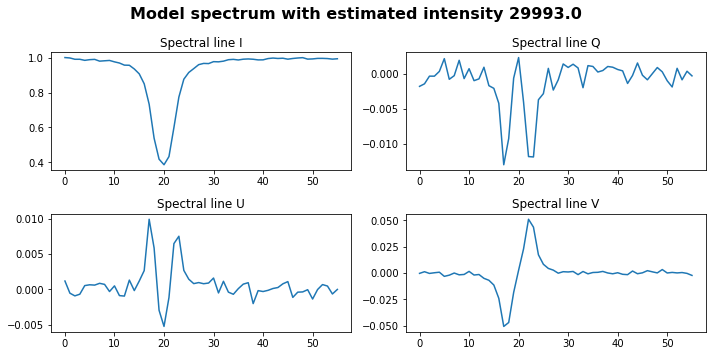

In [31]:
# можно побегать индексами и посравнивать спектры
idx_0, idx_1 = 22, 794
cont_int, real_line = plot_spectrum(sp_folder, date, path_to_refer, idx_0, idx_1)
refer, names = open_param_file(path_to_refer, print_params=False, normalize=False)
profile, cont_int  = plot_model_spectrum(refer, names, idx_0, idx_1)

In [32]:
def prepare_real_mlp(sp_folder, date, factors = None, cont_scale = None, device = None):
    real_samples, cont = read_spectrum_for_refer(sp_folder, date)
    norm_real_samples = normalize_spectrum(np.reshape(real_samples, (-1,56,4), order='F'), factors = factors)
    norm_cont = cont/cont_scale
    norm_real_samples = np.reshape(norm_real_samples, (-1,224), order='F')
    real_x = [torch.from_numpy(norm_real_samples).float().to(device), torch.from_numpy(norm_cont).float().to(device)]
    return real_x


In [33]:
%%time
real_x = prepare_real_mlp(sp_folder, date, factors = factors, cont_scale = cont_scale, device = device)

CPU times: user 3.18 s, sys: 1.65 s, total: 4.83 s
Wall time: 6.89 s


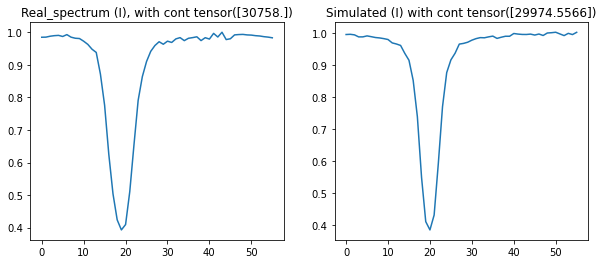

In [34]:
#тоже можно побегать индексом и увидеть, что наши симуляции довольно сильно отличаются
idx = 20000
#можно проверить,  что все правильно сделали и посмотреть на координату пикселя
idx_0, idx_1  = np.where(np.arange(512*873).reshape(512, 873)==idx)
idx_0[0], idx_1[0] = idx_0, idx_1
plt.figure(figsize = (10,4))
plt.subplot(1,2,1); plt.plot(real_x[0][idx, :56]); plt.title(f'Real_spectrum (I), with cont {real_x[1][idx]*40000}')
plt.subplot(1,2,2);  plt.plot(sim_x[0][idx, :56]); plt.title(f'Simulated (I) with cont {sim_x[1][idx]*40000}');


In [35]:
model.eval()
with torch.no_grad():
    predicted_real = model(real_x)

In [36]:
predicted_mean_real = predicted_real[:, :11].detach().cpu().numpy()
predicted_sigma_real = torch.exp(predicted_real[:, 11:]).detach().cpu().numpy()

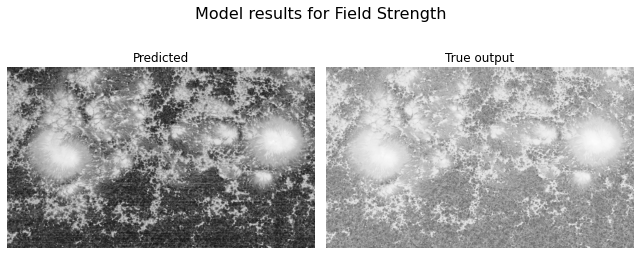

In [37]:
plot_pred_vs_refer(predicted_mean_real, data, output_index=0, save_path=save_path, title='real')

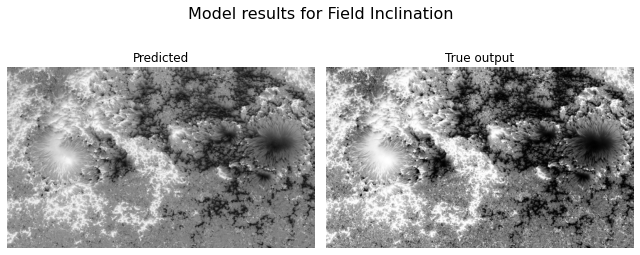

In [38]:
plot_pred_vs_refer(predicted_mean_real, data, output_index=1, save_path=save_path, title='real')

In [39]:
compute_metrics(masked_ref_2d.data, predicted_mean_real,
                save_path=save_path + 'metrics_real.csv',
                mask=masked_ref_2d.mask)

,r2,mse,mae
Field Strength,0.8319,0.0027,0.0380
Field Inclination,0.9675,0.0013,0.0250
Field Azimuth,0.6348,0.0280,0.0911
Doppler Width,0.1854,0.0177,0.0939
Damping,0.2847,0.0133,0.0858
Line Strength,0.1834,0.0116,0.0589
S_0,0.2479,0.0031,0.0420
S_1,0.6665,0.0034,0.0438
Doppler Shift,0.5768,0.0019,0.0369
Filling Factor,0.3502,0.0449,0.1614


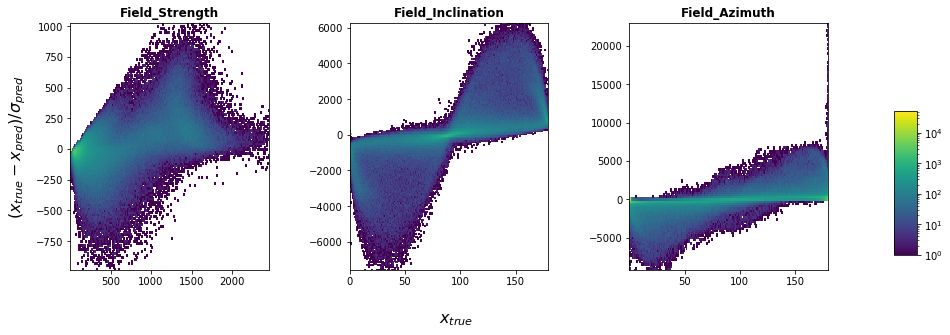

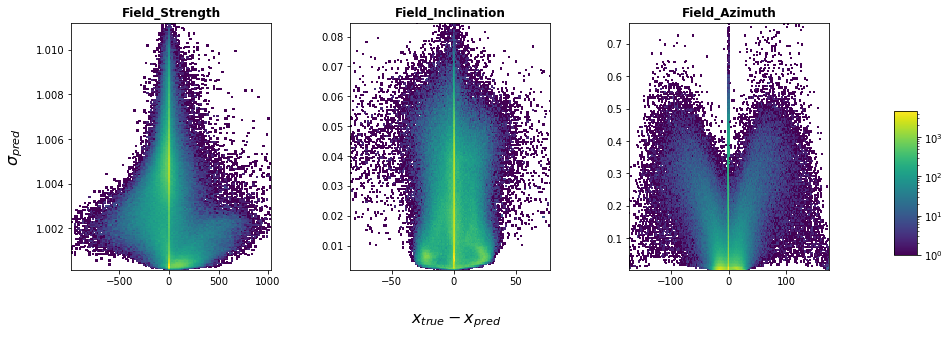

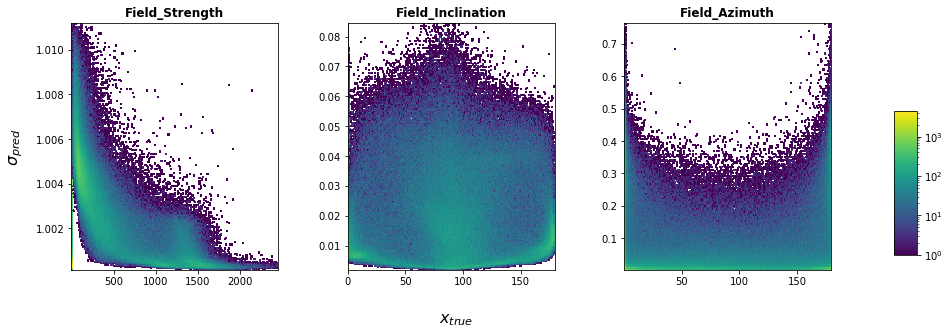

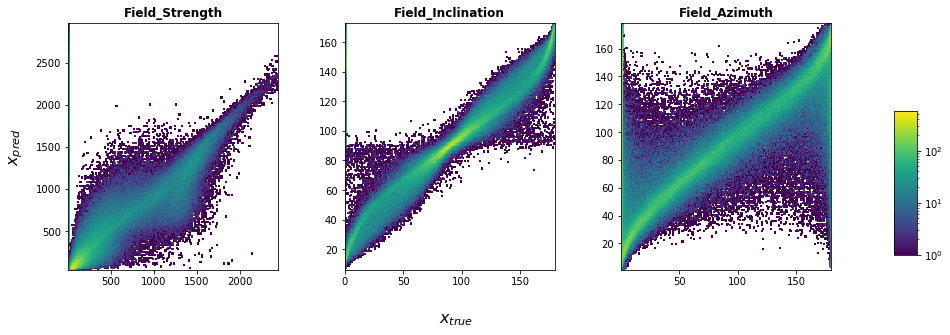

In [125]:
inv_angle_transformation = False
true = inverse_transformation(masked_ref_2d, inv_angle_transformation=inv_angle_transformation)
pred_real = inverse_transformation(predicted_mean_real, inv_angle_transformation=inv_angle_transformation)
sigma_real = inverse_transformation(predicted_sigma_real, sigma=True, inv_angle_transformation=inv_angle_transformation)

plot_analysis_hist2d_unc(names, true, pred_real, sigma_real, index=0, bins=200, save_path=save_path, title='real');
plot_analysis_hist2d_unc(names, true, pred_real, sigma_real, index=1, bins=200, save_path=save_path, title='real');
plot_analysis_hist2d_unc(names, true, pred_real, sigma_real, index=2, bins=200, save_path=save_path, title='real');
plot_analysis_hist2d_unc(names, true, pred_real, sigma_real, index=3, bins=200, save_path=save_path, title='real');



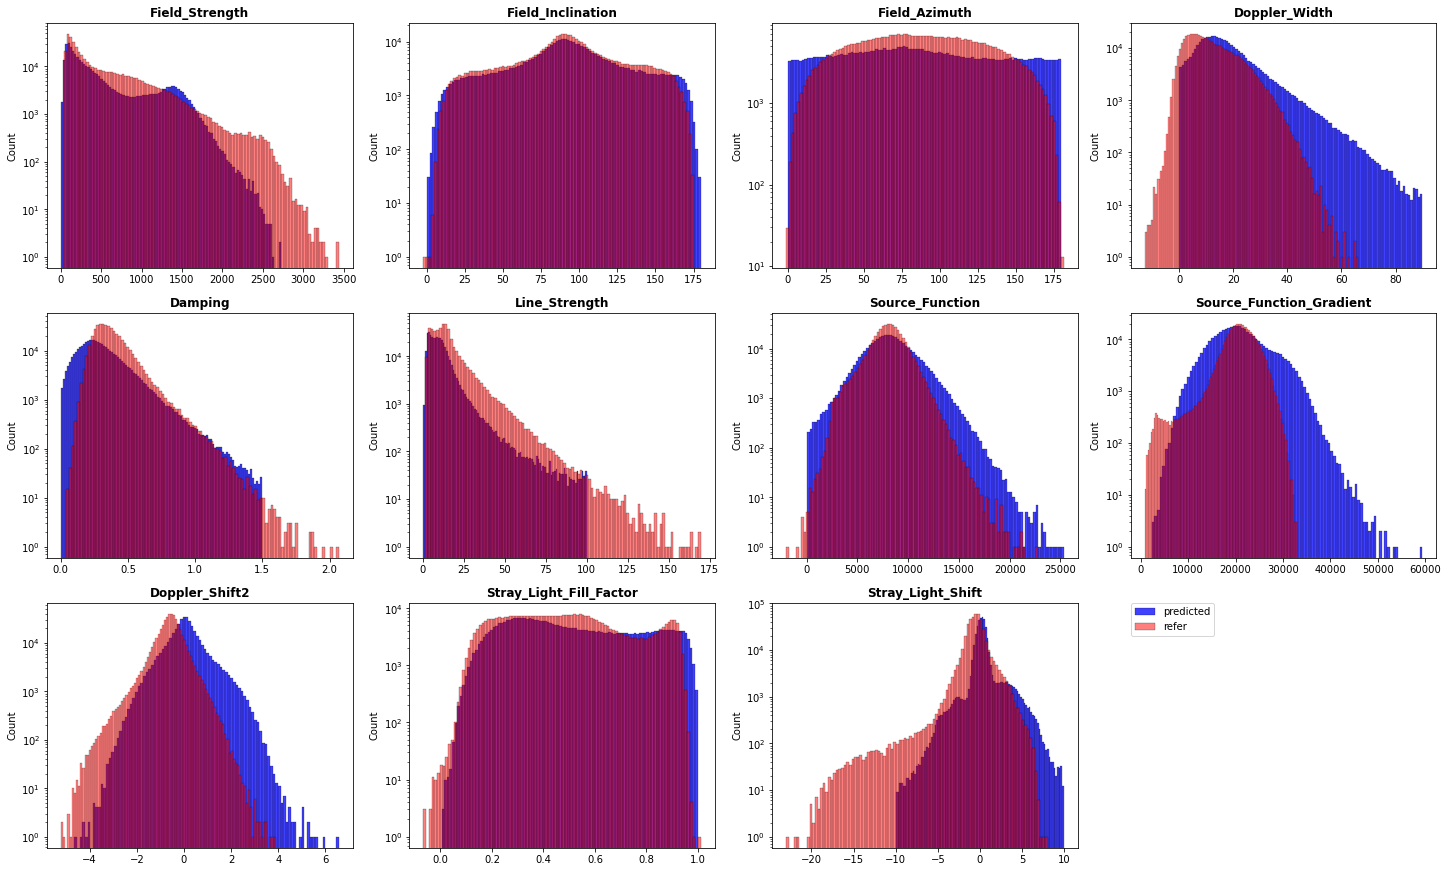

In [41]:
plot_hist_params_comparison(inverse_transformation(masked_ref_2d), inverse_transformation(predicted_mean_real), names, plot_name='real', save_path=save_path)